In [1]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attempt

In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import copy
import time
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
from ptflops import get_model_complexity_info

In [3]:
learning_rate =1e-4
BATCH_SIZE = 32
epoch = 100
model_name = "Resnet18"

In [4]:
path = r"/kaggle/working/" + f"result_{model_name}"
if not os.path.exists(path):
    os.mkdir(path)

In [5]:
train_path= r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/train"
val_path = r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/val"
test_path= r"/kaggle/input/durian-leaf/A Durian Leaf/A Durian Leaf/A_Durian_Leaf_Image_Dataset/Durian_Leaf_Diseases/test"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

data_transform = {
    'Train':transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "Validation": transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'Test': transforms.Compose([
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

train_dataset = datasets.ImageFolder(root=train_path, transform=data_transform["Train"])
val_dataset = datasets.ImageFolder(root=val_path, transform=data_transform["Validation"])
test_dataset = datasets.ImageFolder(root=test_path, transform=data_transform["Test"])

print("Classes:", train_dataset.classes)

print(f"Số lượng ảnh trong tập train: {len(train_dataset)}")
print(f"Số lượng ảnh trong tập val: {len(val_dataset)}")
print(f"Số lượng ảnh trong tập test: {len(test_dataset)}")

Classes: ['Leaf_Algal', 'Leaf_Blight', 'Leaf_Colletotrichum', 'Leaf_Healthy', 'Leaf_Phomopsis', 'Leaf_Rhizoctonia']
Số lượng ảnh trong tập train: 1814
Số lượng ảnh trong tập val: 387
Số lượng ảnh trong tập test: 394


In [6]:
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= True)

data_loader= {"Train": train_loader,
                "Validation": val_loader}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def train_model(data_loader, model, criterion, optimizer, num_epochs, device, early_stop= True, patience=10):
    model= model.to(device)
    model= torch.nn.DataParallel(model)

    since =time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc =0.0
    best_epoch = 0.0
    wait = 0

    history = {"Train_Loss":[],"Train_Acc":[],"Validation_Loss":[],"Validation_Acc":[],"Time":[]}

    result_current = {"Train_Loss": None,
                        "Train_Acc":None,
                        "Validition_Loss": None,
                        "Validition_ACC":None
                     }
    for epoch in range(num_epochs):
        
        print("-----------------------------------------------------------------------")
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_start = time.time()
        
        for phase in ["Train", "Validation"]:
            if phase == "Train":
                model.train()
            else:
                model.eval()

            running_loss, running_correct = 0.0, 0
            total_samples = 0
            
            for images, labels in tqdm(data_loader[phase], desc="Training And Evaluation"):
                images = images.to(device)
                labels = labels.to(device)
                
                with torch.set_grad_enabled(phase=="Train"):
                    outputs = model(images)
                    _, predicts = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "Train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * images.size(0)
                running_correct += torch.sum(predicts == labels).item()
                total_samples += images.size(0)
                
            epoch_loss = running_loss / total_samples
            epoch_acc = running_correct / total_samples

            result_current[f"{phase}_Loss"] = epoch_loss
            result_current[f"{phase}_Acc"] = epoch_acc
            
            history[f"{phase}_Loss"].append(epoch_loss)
            history[f"{phase}_Acc"].append(epoch_acc)

            if phase == "Validation":
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    wait = 0
                else:
                    wait += 1
        epoch_duration= time.time()- epoch_start
        history["Time"].append(epoch_duration)
        print(f"Train Loss: {result_current['Train_Loss']:.4f}, Train Acc: {result_current['Train_Acc']:.4f}")
        print(f"Valid Loss: {result_current['Validation_Loss']:.4f}, Valid Acc: {result_current['Validation_Acc']:.4f}")
        print(f"Epoch {epoch+1} finished in {epoch_duration:.2f}s")
    
        if early_stop and wait >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs).")
            break
    
    print("-----------------------------------------------------------------------")
    time_elapse = time.time() - since
    print(f"Training Complete In {time_elapse}s")
    
    model.load_state_dict(best_model_wts)

    return model, pd.DataFrame(history), time_elapse, best_val_acc, best_epoch

In [10]:
model, history, time_elapse, best_val_acc, best_epoch = train_model(data_loader=data_loader, model=model, 
                                                                    criterion=criterion, optimizer=optimizer, 
                                                                    num_epochs=epoch, device=device, 
                                                                    early_stop=True, patience=10)

-----------------------------------------------------------------------
Epoch 1/100


Training And Evaluation: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


Train Loss: 0.6874, Train Acc: 0.7679
Valid Loss: 0.2643, Valid Acc: 0.9173
Epoch 1 finished in 197.79s
-----------------------------------------------------------------------
Epoch 2/100


Training And Evaluation: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


Train Loss: 0.2447, Train Acc: 0.9173
Valid Loss: 0.2219, Valid Acc: 0.9380
Epoch 2 finished in 188.38s
-----------------------------------------------------------------------
Epoch 3/100


Training And Evaluation: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]


Train Loss: 0.1544, Train Acc: 0.9542
Valid Loss: 0.2063, Valid Acc: 0.9354
Epoch 3 finished in 183.89s
-----------------------------------------------------------------------
Epoch 4/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Train Loss: 0.1042, Train Acc: 0.9642
Valid Loss: 0.1793, Valid Acc: 0.9509
Epoch 4 finished in 182.45s
-----------------------------------------------------------------------
Epoch 5/100


Training And Evaluation: 100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


Train Loss: 0.0920, Train Acc: 0.9713
Valid Loss: 0.2210, Valid Acc: 0.9406
Epoch 5 finished in 191.36s
-----------------------------------------------------------------------
Epoch 6/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Train Loss: 0.0989, Train Acc: 0.9675
Valid Loss: 0.2034, Valid Acc: 0.9457
Epoch 6 finished in 182.72s
-----------------------------------------------------------------------
Epoch 7/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Train Loss: 0.0798, Train Acc: 0.9746
Valid Loss: 0.1959, Valid Acc: 0.9509
Epoch 7 finished in 185.41s
-----------------------------------------------------------------------
Epoch 8/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Train Loss: 0.0535, Train Acc: 0.9840
Valid Loss: 0.1587, Valid Acc: 0.9587
Epoch 8 finished in 188.06s
-----------------------------------------------------------------------
Epoch 9/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Train Loss: 0.0454, Train Acc: 0.9868
Valid Loss: 0.1694, Valid Acc: 0.9612
Epoch 9 finished in 185.20s
-----------------------------------------------------------------------
Epoch 10/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


Train Loss: 0.0400, Train Acc: 0.9890
Valid Loss: 0.1931, Valid Acc: 0.9535
Epoch 10 finished in 185.62s
-----------------------------------------------------------------------
Epoch 11/100


Training And Evaluation: 100%|██████████| 13/13 [00:14<00:00,  1.15s/it]


Train Loss: 0.0439, Train Acc: 0.9868
Valid Loss: 0.1854, Valid Acc: 0.9509
Epoch 11 finished in 187.09s
-----------------------------------------------------------------------
Epoch 12/100


Training And Evaluation: 100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


Train Loss: 0.0323, Train Acc: 0.9879
Valid Loss: 0.1743, Valid Acc: 0.9612
Epoch 12 finished in 185.31s
-----------------------------------------------------------------------
Epoch 13/100


Training And Evaluation: 100%|██████████| 13/13 [00:13<00:00,  1.03s/it]


Train Loss: 0.0272, Train Acc: 0.9934
Valid Loss: 0.1720, Valid Acc: 0.9612
Epoch 13 finished in 185.56s
-----------------------------------------------------------------------
Epoch 14/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Train Loss: 0.0317, Train Acc: 0.9895
Valid Loss: 0.2243, Valid Acc: 0.9406
Epoch 14 finished in 183.78s
-----------------------------------------------------------------------
Epoch 15/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Train Loss: 0.0284, Train Acc: 0.9912
Valid Loss: 0.2259, Valid Acc: 0.9535
Epoch 15 finished in 184.35s
-----------------------------------------------------------------------
Epoch 16/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]


Train Loss: 0.0341, Train Acc: 0.9884
Valid Loss: 0.2307, Valid Acc: 0.9457
Epoch 16 finished in 183.97s
-----------------------------------------------------------------------
Epoch 17/100


Training And Evaluation: 100%|██████████| 13/13 [00:12<00:00,  1.00it/s]


Train Loss: 0.0571, Train Acc: 0.9813
Valid Loss: 0.2578, Valid Acc: 0.9406
Epoch 17 finished in 184.83s
-----------------------------------------------------------------------
Epoch 18/100


Training And Evaluation: 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


Train Loss: 0.0354, Train Acc: 0.9868
Valid Loss: 0.1915, Valid Acc: 0.9457
Epoch 18 finished in 184.93s
-----------------------------------------------------------------------
Epoch 19/100


Training And Evaluation: 100%|██████████| 13/13 [00:14<00:00,  1.12s/it]

Train Loss: 0.0309, Train Acc: 0.9901
Valid Loss: 0.1770, Valid Acc: 0.9483
Epoch 19 finished in 186.26s
Early stopping at epoch 19 (no improvement in 10 epochs).
-----------------------------------------------------------------------
Training Complete In 3536.982792377472s


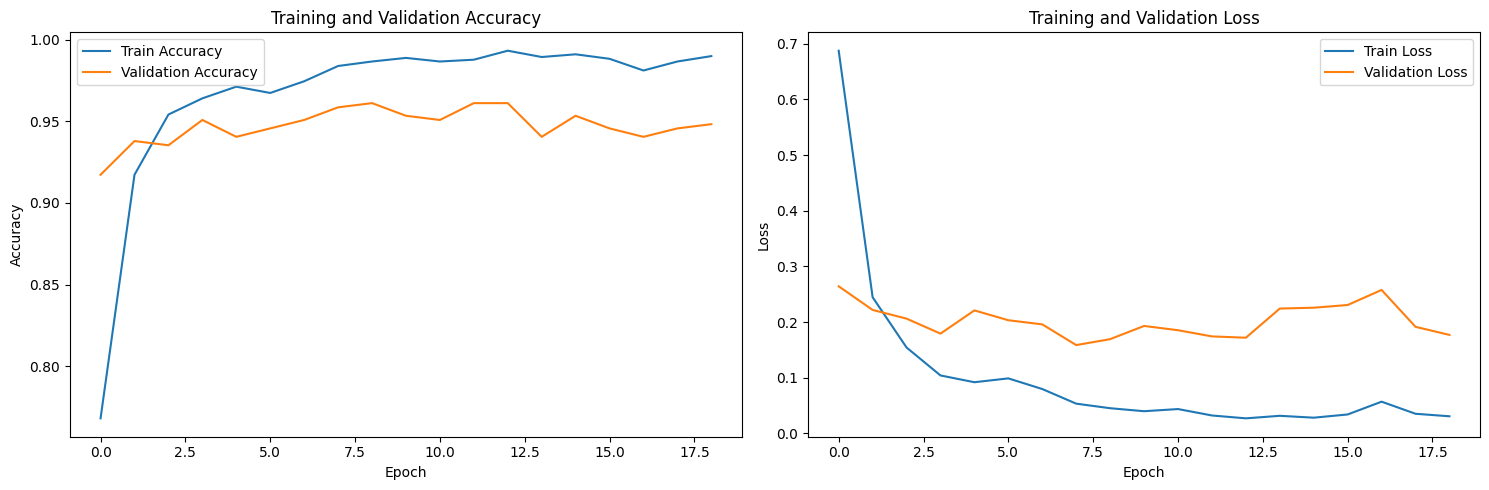

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(history['Train_Acc'], label='Train Accuracy')
axs[0].plot(history['Validation_Acc'], label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].plot(history['Train_Loss'], label='Train Loss')
axs[1].plot(history['Validation_Loss'], label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(path, "plot_loss_acc.png"))
plt.show()

Accuracy: 0.9441624365482234
Precision: 0.9440589757922337
Recall: 0.9441624365482234
F1-Score: 0.9434244010944268
                     precision    recall  f1-score   support

         Leaf_Algal     0.9855    0.9714    0.9784        70
        Leaf_Blight     0.8906    0.8636    0.8769        66
Leaf_Colletotrichum     0.9444    0.8500    0.8947        60
       Leaf_Healthy     0.9737    1.0000    0.9867        74
     Leaf_Phomopsis     0.9403    1.0000    0.9692        63
   Leaf_Rhizoctonia     0.9219    0.9672    0.9440        61

           accuracy                         0.9442       394
          macro avg     0.9427    0.9420    0.9417       394
       weighted avg     0.9441    0.9442    0.9434       394



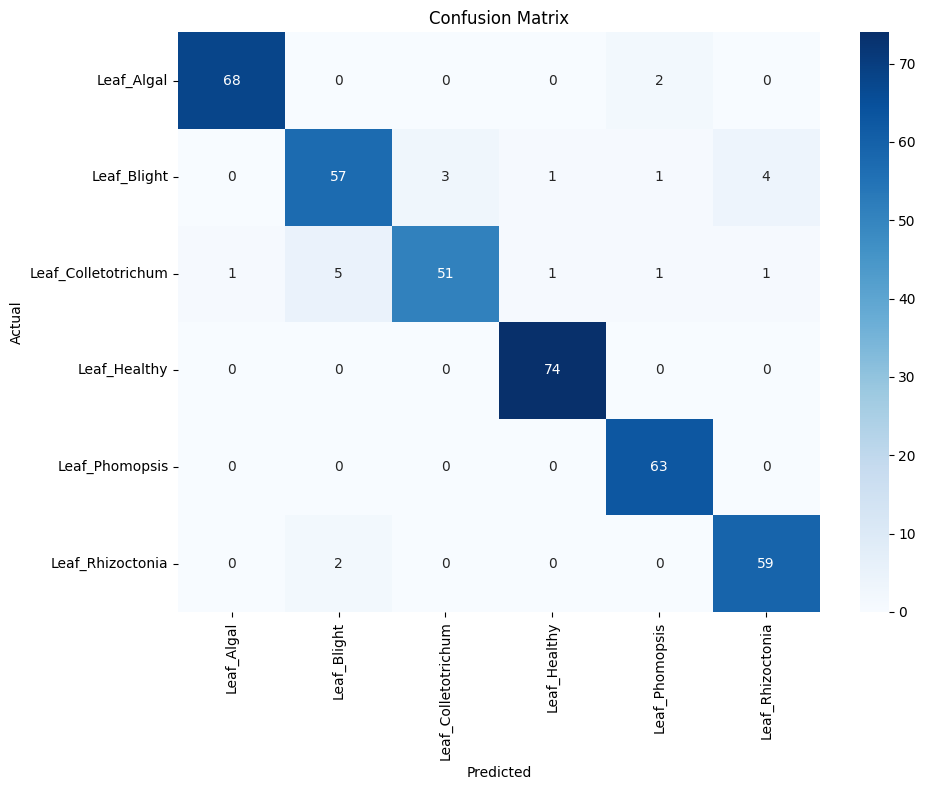

In [12]:
model.eval()

with torch.no_grad():
    
    all_correct = []
    all_predict = []
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicts = torch.max(outputs, dim=1)

        all_correct.extend(labels.cpu().numpy())
        all_predict.extend(predicts.cpu().numpy())

    acc = accuracy_score(all_correct, all_predict)
    precision = precision_score(all_correct, all_predict, average='weighted')
    recall = recall_score(all_correct, all_predict, average='weighted')
    f1 = f1_score(all_correct, all_predict, average='weighted')
    
    input_res = (3, 224, 224)
    flops, params = get_model_complexity_info(model, input_res, as_strings=True, print_per_layer_stat=False)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    result = {
        "Model": model_name,
        "Optimizer": "Adam",
        "Learning_Rate": learning_rate,
        "Batch_Size": BATCH_SIZE,
        "Num_Epoch": epoch,
        "Early_Stop": best_epoch,
        "Training_Time": time_elapse,
        "Best_Val_Acc": best_val_acc,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "FLOPs": flops,
        "Params": params,
        "Total_Params": total_params,
        "Trainable_Params": trainable_params,
             }
    
    result_df = pd.DataFrame([result])
    result_df.to_csv(os.path.join(path, "result.csv"), index=False)
    
    report = classification_report(all_correct, all_predict, target_names=train_dataset.classes, digits=4)
    print(report)
    with open(os.path.join(path, "classification_report.txt"), "w") as f:
        f.write(report)
        
    cm = confusion_matrix(all_correct, all_predict)
    
    # Hiển thị confusion matrix dưới dạng heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.savefig(os.path.join(path, 'confusion_matrix.png'))
    plt.show()
    
    plt.close()

In [13]:
torch.save(model.state_dict(), os.path.join(path, f'{model_name}_weights.pth'))
history.to_csv(os.path.join(path, "history.csv"), index=False)

In [14]:
import shutil

shutil.make_archive(path, 'zip', path)

'/kaggle/working/result_Resnet18.zip'